Accessing GFS data from Amazon S3 bucket and analyzing variables of note (precip, soil moisture)

In [2]:
import fsspec
import xarray as xr
import s3fs


In [3]:
#attmepting remotely open the file to "stream" it, or only access certain parts. 
s3_gfs_nc_path = "s3://noaa-gfs-bdp-pds/gfs.20250623/00/atmos/gfs.t00z.sfcanl.nc"
fs = fsspec.filesystem("s3", anon=True)

with fs.open(s3_gfs_nc_path) as f:
    ds = xr.open_dataset(s3_gfs_nc_path, engine="h5netcdf") #Changed to h5netcdf backend because the netcdf4 backend does not support remotely opening files. 
    

NoCredentialsError: Unable to locate credentials

In [4]:
hour = "00"
s3_gfs_nc_path = f"s3://noaa-gfs-bdp-pds/gfs.20250623/{hour}/atmos/gfs.t{hour}z.sfcanl.nc"
fs = fsspec.filesystem("s3", anon=True)

fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

ds = xr.open_dataset(fs.open(s3_gfs_nc_path, **fsspec_caching), engine="h5netcdf")
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (grid_xt: 3072, grid_yt: 1536, time: 1)
Coordinates:
  * grid_xt  (grid_xt) float64 25kB 0.0 0.1172 0.2344 ... 359.6 359.8 359.9
  * grid_yt  (grid_yt) float64 12kB 89.91 89.79 89.68 ... -89.68 -89.79 -89.91
  * time     (time) object 8B 2025-06-23 00:00:00
Data variables: (12/62)
    lon      (grid_yt, grid_xt) float64 38MB ...
    lat      (grid_yt, grid_xt) float64 38MB ...
    alnsf    (time, grid_yt, grid_xt) float32 19MB ...
    alnwf    (time, grid_yt, grid_xt) float32 19MB ...
    alvsf    (time, grid_yt, grid_xt) float32 19MB ...
    alvwf    (time, grid_yt, grid_xt) float32 19MB ...
    ...       ...
    xtts     (time, grid_yt, grid_xt) float32 19MB ...
    xu       (time, grid_yt, grid_xt) float32 19MB ...
    xv       (time, grid_yt, grid_xt) float32 19MB ...
    xz       (time, grid_yt, grid_xt) float32 19MB ...
    xzts     (time, grid_yt, grid_xt) float32 19MB ...
    zc       (time, grid_yt, grid_xt) float32 19MB ...
Attributes:
    nsoil:    4
    source:   FV3GFS
    grid:     gaussian
    im:       3072
    jm:       1536

In [5]:
ds_us = ds.sel(grid_xt=slice(((180-125.5)+180), ((180-64)+180)),grid_yt=slice(50.2, 22))

In [6]:
ds_us['tprcp']

<xarray.DataArray 'tprcp' (time: 1, grid_yt: 241, grid_xt: 524)> Size: 505kB
[126284 values with dtype=float32]
Coordinates:
  * grid_xt  (grid_xt) float64 4kB 234.6 234.7 234.8 235.0 ... 295.7 295.8 295.9
  * grid_yt  (grid_yt) float64 2kB 50.2 50.08 49.96 49.85 ... 22.32 22.2 22.08
  * time     (time) object 8B 2025-06-23 00:00:00
Attributes:
    long_name:     total precipitation
    units:         kg/m**2
    missing:       9.99e+20
    cell_methods:  time: point
    output_file:   sfc

In [24]:
ds_us_tpcrp_00 = ds_us['tprcp'].where(ds_us['tprcp'] != ds_us['tprcp'].attrs['missing'])

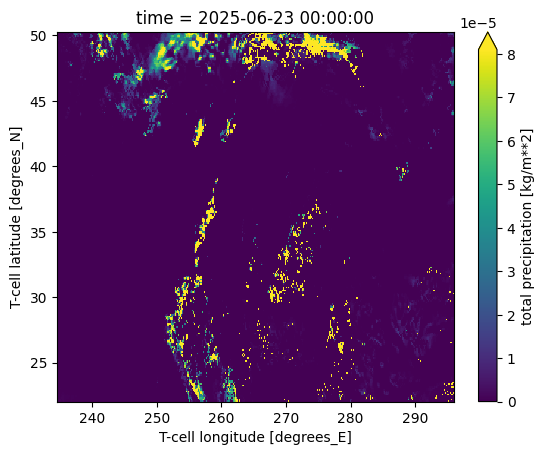

In [25]:
ds_us_tpcrp_00.plot(robust=True)

Now I will try to pull all the 6 hourly files and add them together to get the full 6-23 precipitation, given prism is the full day in mm. 

In [31]:
hour = "06"
s3_gfs_nc_path = f"s3://noaa-gfs-bdp-pds/gfs.20250623/{hour}/atmos/gfs.t{hour}z.sfcanl.nc"
fs = fsspec.filesystem("s3", anon=True)

fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

ds_06 = xr.open_dataset(fs.open(s3_gfs_nc_path, **fsspec_caching), engine="h5netcdf")
ds_06

<xarray.Dataset> Size: 1GB
Dimensions:  (grid_xt: 3072, grid_yt: 1536, time: 1)
Coordinates:
  * grid_xt  (grid_xt) float64 25kB 0.0 0.1172 0.2344 ... 359.6 359.8 359.9
  * grid_yt  (grid_yt) float64 12kB 89.91 89.79 89.68 ... -89.68 -89.79 -89.91
  * time     (time) object 8B 2025-06-23 06:00:00
Data variables: (12/62)
    lon      (grid_yt, grid_xt) float64 38MB ...
    lat      (grid_yt, grid_xt) float64 38MB ...
    alnsf    (time, grid_yt, grid_xt) float32 19MB ...
    alnwf    (time, grid_yt, grid_xt) float32 19MB ...
    alvsf    (time, grid_yt, grid_xt) float32 19MB ...
    alvwf    (time, grid_yt, grid_xt) float32 19MB ...
    ...       ...
    xtts     (time, grid_yt, grid_xt) float32 19MB ...
    xu       (time, grid_yt, grid_xt) float32 19MB ...
    xv       (time, grid_yt, grid_xt) float32 19MB ...
    xz       (time, grid_yt, grid_xt) float32 19MB ...
    xzts     (time, grid_yt, grid_xt) float32 19MB ...
    zc       (time, grid_yt, grid_xt) float32 19MB ...
Attributes:
    nsoil:    4
    source:   FV3GFS
    grid:     gaussian
    im:       3072
    jm:       1536

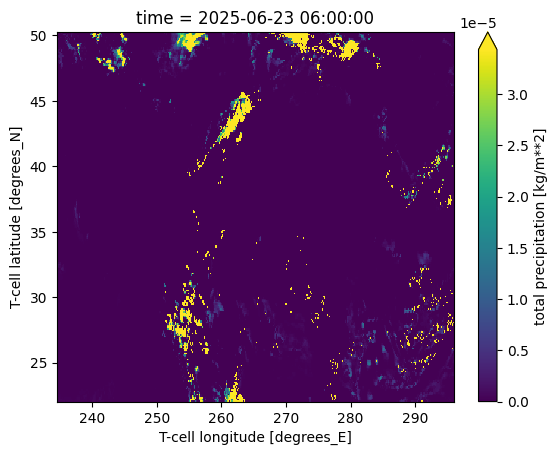

In [32]:
ds_us_06 = ds_06.sel(grid_xt=slice(((180-125.5)+180), ((180-64)+180)),grid_yt=slice(50.2, 22))
ds_us_tpcrp_06 = ds_us_06['tprcp'].where(ds_us_06['tprcp'] != ds_us_06['tprcp'].attrs['missing'])
ds_us_tpcrp_06.plot(robust=True)

In [33]:
hour = "12"
s3_gfs_nc_path = f"s3://noaa-gfs-bdp-pds/gfs.20250623/{hour}/atmos/gfs.t{hour}z.sfcanl.nc"
fs = fsspec.filesystem("s3", anon=True)

fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

ds_12 = xr.open_dataset(fs.open(s3_gfs_nc_path, **fsspec_caching), engine="h5netcdf")
ds_12

<xarray.Dataset> Size: 1GB
Dimensions:  (grid_xt: 3072, grid_yt: 1536, time: 1)
Coordinates:
  * grid_xt  (grid_xt) float64 25kB 0.0 0.1172 0.2344 ... 359.6 359.8 359.9
  * grid_yt  (grid_yt) float64 12kB 89.91 89.79 89.68 ... -89.68 -89.79 -89.91
  * time     (time) object 8B 2025-06-23 12:00:00
Data variables: (12/62)
    lon      (grid_yt, grid_xt) float64 38MB ...
    lat      (grid_yt, grid_xt) float64 38MB ...
    alnsf    (time, grid_yt, grid_xt) float32 19MB ...
    alnwf    (time, grid_yt, grid_xt) float32 19MB ...
    alvsf    (time, grid_yt, grid_xt) float32 19MB ...
    alvwf    (time, grid_yt, grid_xt) float32 19MB ...
    ...       ...
    xtts     (time, grid_yt, grid_xt) float32 19MB ...
    xu       (time, grid_yt, grid_xt) float32 19MB ...
    xv       (time, grid_yt, grid_xt) float32 19MB ...
    xz       (time, grid_yt, grid_xt) float32 19MB ...
    xzts     (time, grid_yt, grid_xt) float32 19MB ...
    zc       (time, grid_yt, grid_xt) float32 19MB ...
Attributes:
    nsoil:    4
    source:   FV3GFS
    grid:     gaussian
    im:       3072
    jm:       1536

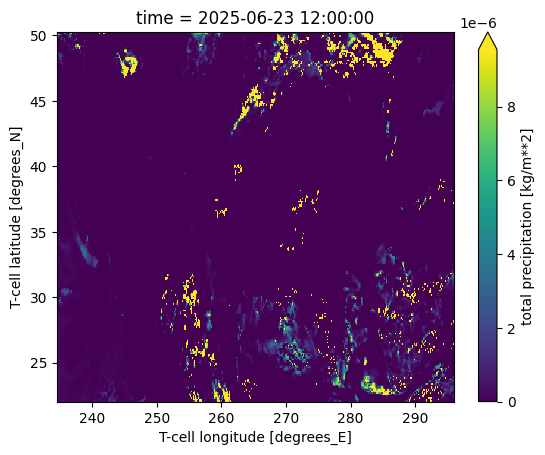

In [34]:
ds_us_12 = ds_12.sel(grid_xt=slice(((180-125.5)+180), ((180-64)+180)),grid_yt=slice(50.2, 22))
ds_us_tpcrp_12 = ds_us_12['tprcp'].where(ds_us_12['tprcp'] != ds_us_12['tprcp'].attrs['missing'])
ds_us_tpcrp_12.plot(robust=True)

In [35]:
hour = "18"
s3_gfs_nc_path = f"s3://noaa-gfs-bdp-pds/gfs.20250623/{hour}/atmos/gfs.t{hour}z.sfcanl.nc"
fs = fsspec.filesystem("s3", anon=True)

fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

ds_18 = xr.open_dataset(fs.open(s3_gfs_nc_path, **fsspec_caching), engine="h5netcdf")
ds_18

<xarray.Dataset> Size: 1GB
Dimensions:  (grid_xt: 3072, grid_yt: 1536, time: 1)
Coordinates:
  * grid_xt  (grid_xt) float64 25kB 0.0 0.1172 0.2344 ... 359.6 359.8 359.9
  * grid_yt  (grid_yt) float64 12kB 89.91 89.79 89.68 ... -89.68 -89.79 -89.91
  * time     (time) object 8B 2025-06-23 18:00:00
Data variables: (12/62)
    lon      (grid_yt, grid_xt) float64 38MB ...
    lat      (grid_yt, grid_xt) float64 38MB ...
    alnsf    (time, grid_yt, grid_xt) float32 19MB ...
    alnwf    (time, grid_yt, grid_xt) float32 19MB ...
    alvsf    (time, grid_yt, grid_xt) float32 19MB ...
    alvwf    (time, grid_yt, grid_xt) float32 19MB ...
    ...       ...
    xtts     (time, grid_yt, grid_xt) float32 19MB ...
    xu       (time, grid_yt, grid_xt) float32 19MB ...
    xv       (time, grid_yt, grid_xt) float32 19MB ...
    xz       (time, grid_yt, grid_xt) float32 19MB ...
    xzts     (time, grid_yt, grid_xt) float32 19MB ...
    zc       (time, grid_yt, grid_xt) float32 19MB ...
Attributes:
    nsoil:    4
    source:   FV3GFS
    grid:     gaussian
    im:       3072
    jm:       1536

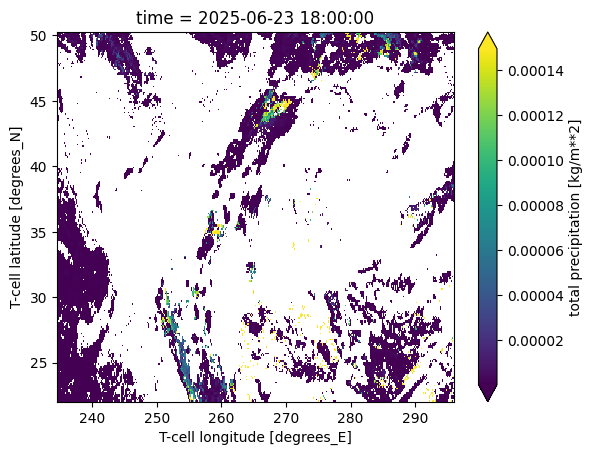

In [67]:
ds_us_18 = ds_18.sel(grid_xt=slice(((180-125.5)+180), ((180-64)+180)),grid_yt=slice(50.2, 22))
ds_us_tpcrp_18 = ds_us_18['tprcp'].where(ds_us_18['tprcp'] != 0)
ds_us_tpcrp_18.plot(robust=True)

In [47]:
ds_tpcrp_total = xr.concat([ds_us_tpcrp_00, ds_us_tpcrp_06, ds_us_tpcrp_12, ds_us_tpcrp_18], dim="time")

In [48]:
ds_tpcrp_total

<xarray.DataArray 'tprcp' (time: 4, grid_yt: 241, grid_xt: 524)> Size: 2MB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.29854006e-05, 1.32361274e-05, 5.73603984e-06],
        [0.00000000e+00, 0.00000000e+00, 8.09552247e-09, ...,
         1.47484452e-05, 1.47484452e-05, 9.80452387e-06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.69860937e-06, 1.69860937e-06, 8.40011671e-06],
        ...,
        [6.74533567e-07, 4.22825934e-07, 4.22825934e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.07235836e-07, 7.76381398e-07, 7.76381398e-07, ...,
         1.73138906e-04, 0.00000000e+00, 0.00000000e+00],
        [7.94021048e-07, 7.94021048e-07, 6.13683198e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.61781399e-10, 1.31662816e-07, 1.31662816e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.50628899e-13, 3.18951896e-13, 5.43079864e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.22000562e-13, 1.15292107e-12, 1.15292107e-12, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         0.00000000e+00, 0.00000000e+00, 6.65069024e-07],
        [7.51975264e-08, 1.00392910e-07, 1.00392910e-07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.76364052e-08, 2.76364052e-08, 7.88189709e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.51515962e-06, 1.94628797e-06, 1.94628797e-06, ...,
         6.17523827e-13, 6.20343566e-13, 0.00000000e+00],
        [1.22102017e-06, 1.06908442e-06, 2.06476699e-07, ...,
         1.17988865e-12, 1.17988865e-12, 1.22824006e-12],
        [3.37197918e-07, 1.04490718e-08, 1.04490718e-08, ...,
         1.17967810e-12, 1.17967810e-12, 1.27568117e-12],
        ...,
        [1.21660420e-07, 8.83403359e-08, 8.83403359e-08, ...,
         3.17300781e-08, 1.86809590e-08, 1.75082029e-08],
        [1.06264885e-07, 7.78650175e-08, 7.78650175e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.98838834e-08, 8.98838834e-08, 7.95487338e-08, ...,
         3.79044766e-04, 1.94428083e-07, 0.00000000e+00]]],
      shape=(4, 241, 524), dtype=float32)
Coordinates:
  * grid_xt  (grid_xt) float64 4kB 234.6 234.7 234.8 235.0 ... 295.7 295.8 295.9
  * grid_yt  (grid_yt) float64 2kB 50.2 50.08 49.96 49.85 ... 22.32 22.2 22.08
  * time     (time) object 32B 2025-06-23 00:00:00 ... 2025-06-23 18:00:00
Attributes:
    long_name:     total precipitation
    units:         kg/m**2
    missing:       9.99e+20
    cell_methods:  time: point
    output_file:   sfc

In [52]:
ds_tpcrp_total['total_tpcrp'] = ds_tpcrp_total.sum(dim="time")

In [53]:
ds_tpcrp_total['total_tpcrp']

<xarray.DataArray 'total_tpcrp' (grid_yt: 241, grid_xt: 524)> Size: 505kB
array([[8.82945551e-06, 5.01187151e-06, 5.01187151e-06, ...,
        1.29854025e-05, 1.32361292e-05, 5.73604029e-06],
       [1.76767423e-06, 5.92994365e-06, 8.61871740e-06, ...,
        1.47484470e-05, 1.47484470e-05, 9.80452478e-06],
       [3.79244170e-07, 1.91907066e-06, 1.91907066e-06, ...,
        1.69861107e-06, 1.69861107e-06, 8.40011762e-06],
       ...,
       [1.39176211e-06, 1.02258321e-06, 1.02258321e-06, ...,
        1.85242058e-07, 1.66247617e-07, 6.82577252e-07],
       [1.21364485e-06, 1.19674462e-06, 1.19674462e-06, ...,
        1.73305452e-04, 0.00000000e+00, 0.00000000e+00],
       [1.25590270e-06, 1.25590270e-06, 1.01118019e-06, ...,
        3.79074248e-04, 3.82804501e-07, 9.03522022e-08]],
      shape=(241, 524), dtype=float32)
Coordinates:
  * grid_xt      (grid_xt) float64 4kB 234.6 234.7 234.8 ... 295.7 295.8 295.9
  * grid_yt      (grid_yt) float64 2kB 50.2 50.08 49.96 ... 22.32 22.2 22.08
    total_tpcrp  (grid_yt, grid_xt) float32 505kB 8.829e-06 ... 9.035e-08

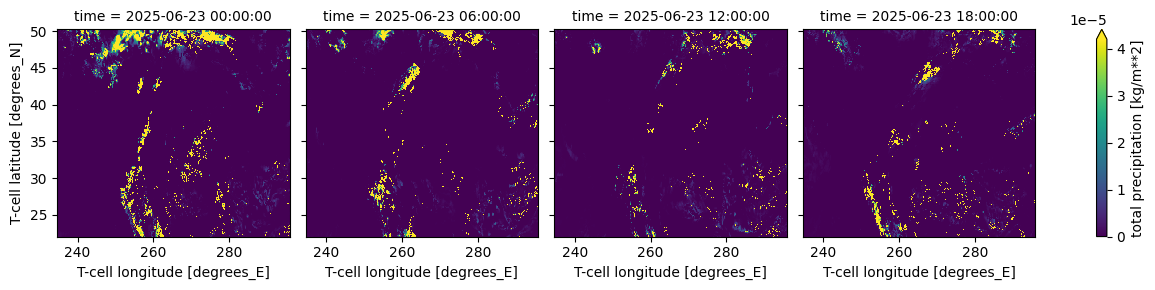

In [57]:
ds_tpcrp_total.plot(col="time", robust=True)

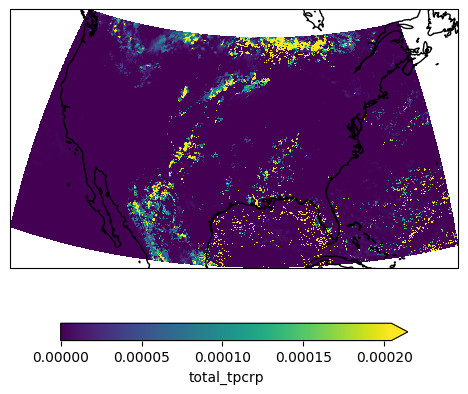

In [68]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30)))


ds_tpcrp_total['total_tpcrp'].plot(ax=axis, transform=ccrs.PlateCarree(), cbar_kwargs={"orientation": "horizontal", "shrink": 0.7}, robust=True)

axis.coastlines()